# 3. 카메라 스티커앱 만들기 첫걸음
- 학습 목표
    - 얼굴인식 카메라의 흐름 이해
    - dlib 라이브러리 사용
    - 이미지 배열의 인덱싱 예외 처리

## 3.2 어떻게 만들까? 사진 준비하기
- 눈,코,입,귀와 같은 얼굴 각각의 위치를 아는 것이 중요한데 이 위치들을 찾아내는 기술을 랜드마크 또는 조정이라고 한다

이미지 처리를 위해 opencv와 노트북에 이미지를 출력하기 위한 matplotlib를 읽어온다

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


### cv2
- 이미지 읽어오기 : cv2.imread(imgFile, flag)
    - imgFile : 이미지 파일 경로
    - flag : 이미지 파일을 읽어올 때 옵션
    - 1 : IMREAD_COLOR : color(BGR)로 읽기, defult값, flag를 생략하면 자동으로 1로 인식
    - 0 : IMREAD_GRAYSCALE : gray-scale로 읽기
    - -1 : IMREAD_UNCHANGED : color(BGR) + alpha channel 까지 포함하여 읽기
- 이미지 출력하기 : cv2.imshow('title', img)
    - title : windows창 이름
    - img : 이미지 파일
- 이미지 저장하기 : cv2.imwrite(dstFile, src)
    - dstFile : 저장될 파일 경로 + 파일명
    - src : 원본 이미지 파일
- 이미지 사이즈 변경 :  cv2.resize()
- 이미지 컬러 공간 변환 : cv2.cvtColor()
    

---

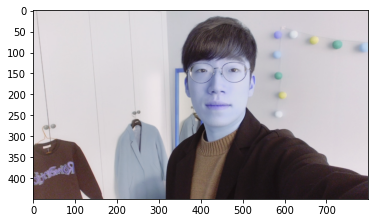

In [22]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

- opencv의 특징 때문에 얼굴 색에 푸른빛이 감돈다.
- matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용하는 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용
- 그래서 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바꾸어 출력

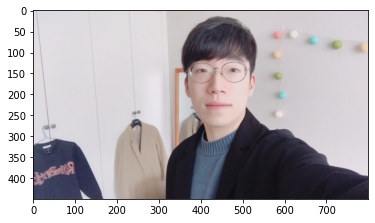

In [23]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html

## 3.3 얼굴 검출 face detection
- dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다
- HOG : 이미지에서 색상의 변화량을 나타낸다
- SVM : 선형 분류기. 이미지는 여러 벡터가 될텐데 이 여러 벡터를 잘 구분짓는 방법. 여기서는 얼굴이냐 아니냐.
- sliding window : 얼굴의 위치를 찾는다. 작은 영역(window)을 이동해가며 확인하는 방법. 큰 이미지의 작은 영역을 잘라 얼굴이 있는지 확인하고, 다시 작은 영역을 옆으로 옮겨 얼굴이 있는지 확인하는 방식. 이미지가 크면 클수록 오래걸리는 단점이 있다

In [24]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


detector_hog 를 이용해서 얼굴의 bounding box를 추출 

In [25]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


- dlib은 rgb 이미지를 입력받기 때문에 cvtColor() 를 이용해서 opencv의 bgr 이미지를 rgb로 변환
- detector_hog의 두 번째 파라미터는 이미지 피라미드의 수
- 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 한다
    - upsampling : 간단하게 데이터의 크기를 키우는 것. 일반적으로 CNN의 레이어를 통과하면서 이미지의 크기를 줄이는 것을 down sampling이라고 하는데, down sampling의 반대 개념이 upsampling

rectangles[[(345, 98) (531, 284)]]


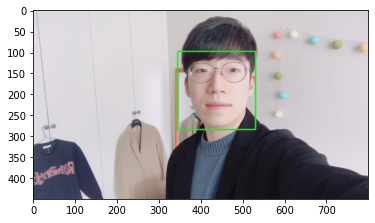

In [10]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- dlib detector는 dlib.rectangles 타입의 객체를 반환
- dlib.rectangles는 dlib.rectangle 객체의 배열 형태로 이루어져 있다
- dlib.rectangle 객체는 left(), top(), right(), bottom(), height(), width()등의 멤버 함수를 포함
- http://dlib.net/python/index.html#dlib.rectangles

## 3.4 얼굴 랜드마크 face landmark
- 이목구비의 위치를 추론하는 것을 face landmark localization기술이라고 한다
- face landmark는 detection 의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지를 이용

### Object keypoint estimation 알고리즘
- Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 한다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 진다
    1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
    2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

### Dlib landmark localization

In [26]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


landmark_predictor 는 RGB 이미지와 dlib.rectangel 을 입력받아 dlib.full_object_detection 를 반환

In [27]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있다. 조금 더 직관적인 (x,y) 형태로 접근할 수 있도록 변환

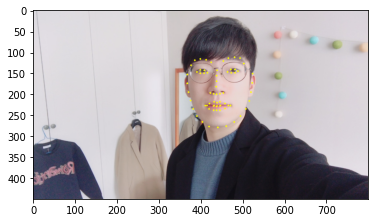

In [29]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3.5 스티커 적용하기

In [30]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)


In [15]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [16]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,-98)


In [17]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,0)


In [32]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

슝~


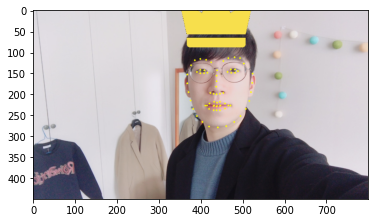

In [33]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

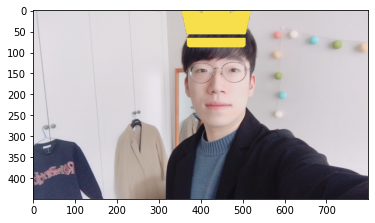

In [34]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()